In [ ]:
import kagglehub

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [ ]:
path = kagglehub.dataset_download("bhaveshmittal/melanoma-cancer-dataset")

Using Colab cache for faster access to the 'melanoma-cancer-dataset' dataset.


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/melanoma-cancer-dataset


In [ ]:
train_data = datasets.ImageFolder(root=os.path.join(path, 'train'), transform=transform)

In [ ]:
test_data = datasets.ImageFolder(root=os.path.join(path, 'test'), transform=transform)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 11879
    Root location: /kaggle/input/melanoma-cancer-dataset/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
test_data

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /kaggle/input/melanoma-cancer-dataset/test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
Conv1 =  nn.Conv2d(3, 6, 3, 1)
Conv2 =  nn.Conv2d(6, 12, 3, 1)
Conv3 =  nn.Conv2d(12, 24, 3, 1)

In [ ]:
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [ ]:
X_Train.shape

torch.Size([3, 224, 224])

In [ ]:
x = X_Train.view(1, 3, 224, 224)

In [ ]:
x = F.relu(Conv1(x))

In [ ]:
x.shape

torch.Size([1, 6, 222, 222])

In [ ]:
x = F.max_pool2d(x,2,2)

In [ ]:
x.shape

torch.Size([1, 6, 111, 111])

In [ ]:
x = F.relu(Conv2(x))

In [ ]:
x.shape

torch.Size([1, 12, 109, 109])

In [ ]:
x = F.max_pool2d(x,2,2)

In [ ]:
x = F.relu(Conv3(x))

In [ ]:
x = F.max_pool2d(x,2,2)

In [ ]:
x.shape

torch.Size([1, 24, 26, 26])

In [ ]:
# Model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.Conv1 = nn.Conv2d(3, 6, 3, 1)
    self.Conv2 = nn.Conv2d(6, 12, 3, 1)
    self.Conv3 = nn.Conv2d(12, 24, 3, 1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(26*26*24, 10000)
    self.fc2 = nn.Linear(10000, 7000)
    self.fc3 = nn.Linear(7000, 4000)
    self.fc4 = nn.Linear(4000, 1000)
    self.fc5 = nn.Linear(1000, 100)
    self.fc6 = nn.Linear(100, 10)
  def forward(self, X):
    #First Pass

    X = F.relu(self.Conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.Conv2(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Third Pass
    X = F.relu(self.Conv3(X))
    X = F.max_pool2d(X,2,2)

    # Re-View to flatten it out
    X = X.view(-1, 24*26*26) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = F.relu(self.fc3(X))
    X = F.relu(self.fc4(X))
    X = F.relu(self.fc5(X))
    X = self.fc6(X)
    return F.log_softmax(X, dim=1)


In [ ]:
torch.manual_seed(41)
model = ConvolutionalNetwork()

In [ ]:
if torch.cuda.is_available():
    print("GPU is available. Using GPU for training.")
    device = torch.device("cuda")
else:
    print("GPU is not available. Using CPU for training.")
    print("Consider enabling GPU in Runtime > Change runtime type for faster training.")
    device = torch.device("cpu")

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

GPU is available. Using GPU for training.
ConvolutionalNetwork(
  (Conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (Conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (Conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=16224, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=7000, bias=True)
  (fc3): Linear(in_features=7000, out_features=4000, bias=True)
  (fc4): Linear(in_features=4000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
import time
start_time = time.time()

epochs = 2

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    running_correct = 0
    total_train = 0

    for batch_idx, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        # forward
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # backward + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate loss *per sample*
        batch_size = y_train.size(0)
        running_loss += loss.item() * batch_size

        # accumulate correct predictions
        predicted = torch.max(y_pred, 1)[1]
        running_correct += (predicted == y_train).sum().item()
        total_train += batch_size

        # occasional logging, not every batch
        if (batch_idx + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Batch [{batch_idx+1}/{len(train_loader)}] "
                  f"Loss: {loss.item():.4f}")

    # epoch-level metrics
    epoch_train_loss = running_loss / total_train
    epoch_train_acc  = running_correct / total_train

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    #####################
    #     VALIDATION    #
    #####################
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    total_val = 0

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            y_out = model(X_val)
            v_loss = criterion(y_out, y_val)

            batch_size = y_val.size(0)
            val_running_loss += v_loss.item() * batch_size

            predicted = torch.max(y_out, 1)[1]
            val_running_correct += (predicted == y_val).sum().item()
            total_val += batch_size

    epoch_val_loss = val_running_loss / total_val
    epoch_val_acc  = val_running_correct / total_val

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"\nEpoch {epoch+1}/{epochs}: "
          f"train_loss={epoch_train_loss:.4f}, "
          f"train_acc={epoch_train_acc:.4f}, "
          f"val_loss={epoch_val_loss:.4f}, "
          f"val_acc={epoch_val_acc:.4f}\n")

total = time.time() - start_time
print(f"Training Took: {total/60:.2f} minutes!")


Epoch [1/2] Batch [50/372] Loss: 1.3262
Epoch [1/2] Batch [100/372] Loss: 0.3288
Epoch [1/2] Batch [150/372] Loss: 0.3669
Epoch [1/2] Batch [200/372] Loss: 0.3618
Epoch [1/2] Batch [250/372] Loss: 0.4229
Epoch [1/2] Batch [300/372] Loss: 0.4499
Epoch [1/2] Batch [350/372] Loss: 0.4069

Epoch 1/2: train_loss=0.3766, train_acc=0.8391, val_loss=0.5115, val_acc=0.7650

Epoch [2/2] Batch [50/372] Loss: 0.5751
Epoch [2/2] Batch [100/372] Loss: 0.3031
Epoch [2/2] Batch [150/372] Loss: 0.2860
Epoch [2/2] Batch [200/372] Loss: 0.4580
Epoch [2/2] Batch [250/372] Loss: 0.3765
Epoch [2/2] Batch [300/372] Loss: 0.4619
Epoch [2/2] Batch [350/372] Loss: 0.2007

Epoch 2/2: train_loss=0.3577, train_acc=0.8439, val_loss=0.3614, val_acc=0.8305

Training Took: 2.09 minutes!


In [ ]:
if torch.cuda.is_available():
    print("GPU is available. Using GPU for training.")
    device = torch.device("cuda")
else:
    print("GPU is not available. Using CPU for training.")
    print("Consider enabling GPU in Runtime > Change runtime type for faster training.")
    device = torch.device("cpu")

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

GPU is available. Using GPU for training.


To utilize the GPU, you would also need to send your data (tensors) to the `device` (GPU) before passing them to the model, like this:

```python
# Inside your training loop:
X_train, y_train = X_train.to(device), y_train.to(device)
# Inside your test loop:
X_test, y_test = X_test.to(device), y_test.to(device)
```

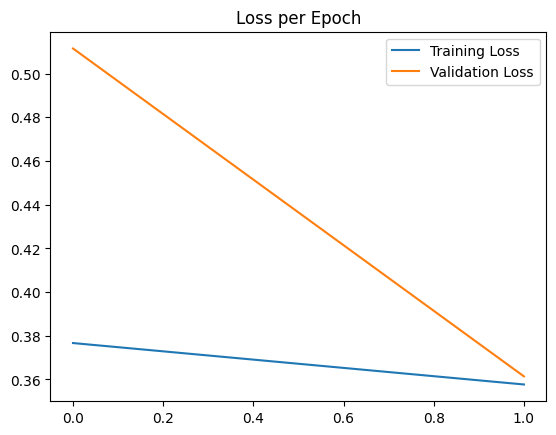

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()


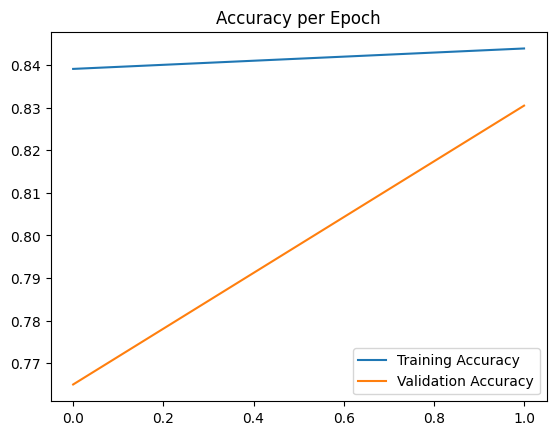

In [ ]:
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()


In [ ]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
correct.item()/len(test_data)*100

83.05

In [ ]:
test_data[1978]

(tensor([[[0.6549, 0.6510, 0.6471,  ..., 0.3882, 0.3686, 0.3725],
          [0.6510, 0.6471, 0.6471,  ..., 0.3647, 0.3569, 0.3569],
          [0.6431, 0.6431, 0.6431,  ..., 0.3725, 0.3647, 0.3608],
          ...,
          [0.4392, 0.4471, 0.4549,  ..., 0.4039, 0.4078, 0.4078],
          [0.4510, 0.4510, 0.4510,  ..., 0.3961, 0.4039, 0.4000],
          [0.4588, 0.4510, 0.4431,  ..., 0.3922, 0.3961, 0.3961]],
 
         [[0.6667, 0.6627, 0.6588,  ..., 0.3333, 0.3255, 0.3294],
          [0.6627, 0.6588, 0.6588,  ..., 0.3216, 0.3137, 0.3137],
          [0.6549, 0.6549, 0.6549,  ..., 0.3294, 0.3176, 0.3216],
          ...,
          [0.3882, 0.3961, 0.4039,  ..., 0.4549, 0.4471, 0.4471],
          [0.3961, 0.3961, 0.3961,  ..., 0.4471, 0.4431, 0.4392],
          [0.4039, 0.3961, 0.3882,  ..., 0.4431, 0.4353, 0.4353]],
 
         [[0.7020, 0.6980, 0.6941,  ..., 0.3294, 0.3176, 0.3216],
          [0.6980, 0.6941, 0.6941,  ..., 0.3137, 0.3059, 0.3059],
          [0.6824, 0.6824, 0.6824,  ...,

In [ ]:
test_data[1978][0]

tensor([[[0.6549, 0.6510, 0.6471,  ..., 0.3882, 0.3686, 0.3725],
         [0.6510, 0.6471, 0.6471,  ..., 0.3647, 0.3569, 0.3569],
         [0.6431, 0.6431, 0.6431,  ..., 0.3725, 0.3647, 0.3608],
         ...,
         [0.4392, 0.4471, 0.4549,  ..., 0.4039, 0.4078, 0.4078],
         [0.4510, 0.4510, 0.4510,  ..., 0.3961, 0.4039, 0.4000],
         [0.4588, 0.4510, 0.4431,  ..., 0.3922, 0.3961, 0.3961]],

        [[0.6667, 0.6627, 0.6588,  ..., 0.3333, 0.3255, 0.3294],
         [0.6627, 0.6588, 0.6588,  ..., 0.3216, 0.3137, 0.3137],
         [0.6549, 0.6549, 0.6549,  ..., 0.3294, 0.3176, 0.3216],
         ...,
         [0.3882, 0.3961, 0.4039,  ..., 0.4549, 0.4471, 0.4471],
         [0.3961, 0.3961, 0.3961,  ..., 0.4471, 0.4431, 0.4392],
         [0.4039, 0.3961, 0.3882,  ..., 0.4431, 0.4353, 0.4353]],

        [[0.7020, 0.6980, 0.6941,  ..., 0.3294, 0.3176, 0.3216],
         [0.6980, 0.6941, 0.6941,  ..., 0.3137, 0.3059, 0.3059],
         [0.6824, 0.6824, 0.6824,  ..., 0.3216, 0.3176, 0.

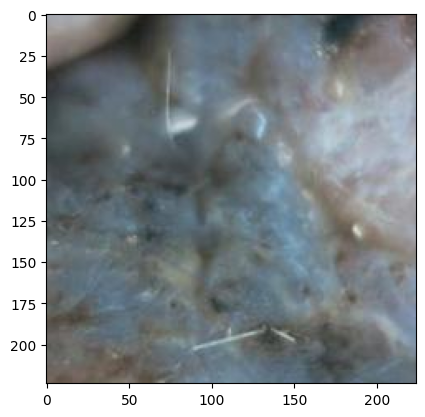

In [ ]:
plt.imshow(test_data[1978][0].permute(1, 2, 0))
plt.show()
